In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import time

from utils_demo_growth import MT_perform_traversal, MT_denoise_local
from utils_train import train_network

In [2]:
train_file = os.path.join('data', 'datawaves_100000_spinsFalse_nonuniform.npy')
test_file = os.path.join('data', 'datawaves_20000_spinsFalse_nonuniform.npy')

train_waves = np.load(train_file)
test_waves = np.load(test_file)

In [3]:
X_natural_train = train_waves.T
X_natural_test = test_waves.T

X_natural_train = X_natural_train#[:, :10000]
X_natural_test = X_natural_test#[:, :2000]

N_train = X_natural_train.shape[1]
N_test = X_natural_test.shape[1]
D = X_natural_train.shape[0]
d = 2

sigma = 0.01
np.random.seed(42)
X_train = X_natural_train + sigma * np.random.randn(D, N_train)
X_test = X_natural_test + sigma * np.random.randn(D, N_test)

print(f"Data loaded: {N_train} training samples, {D} dimensions")

Data loaded: 100000 training samples, 2048 dimensions


In [4]:
def train_network_wrapper(R_is_const, R_denoising, R_1st_order_nbrs, d_parallel, prod_coeff, exp_coeff, name):
    # initialize an MTN object
    M = 0  # number of landmarks

    "local approximation info"
    Q = []  # list of landmarks w
    T = []  # list of basis matrices
    S_collection = []  # a list of sigma matrices obtained after each TISVD

    P = []  # number of points in each approximation

    "first order graph info"
    N1 = []  # list of lists of first order neighbors
    W1 = []  # list of lists of weights of first order neighbors
    Xi = []  # list of lists of edge embeddings

    "zero order graph info"
    N0 = []  # list of lists of zero order neighbors
    W0 = []  # list of lists of weights of zero order neighbors
    tangent_colors = []

    local_params = [Q, T, S_collection, P, Xi]
    nbrs_info = [N1, W1, N0, W0]
    misc = [tangent_colors, D, d, M, P]
    network_params = [local_params, nbrs_info, misc]
    N_cur = 0

    all_MT_SE = []
    mean_MT_SE = []
    mean_data_SE = []

    errors = [mean_MT_SE, mean_data_SE, all_MT_SE]
    other_params = (sigma, R_1st_order_nbrs)
    Rd_params = (R_is_const, R_denoising, d_parallel, prod_coeff, exp_coeff)

    # train online method in batches:
    batch_size = 2000  # set batch_size as desired
    num_batches = N_train // batch_size
    time_array = []
    errors_array = []
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = start_index + batch_size
        cur_time, errors, network_params = train_network(start_index, end_index, errors, network_params, X=X_train,
                                                         X_natural=X_natural_train,
                                                         other_params=other_params, Rd_params=Rd_params)
        time_array.append(cur_time)
        errors_array.append(errors)
        print(f"{end_index} samples processed...")

    print(f"DONE... TOTAL TIME = {np.sum(np.array(time_array))}")
    return network_params, errors

def exhaustive_search(x, Q, calc_mults=True):
    exh_mults = 0
    distances = np.sum((Q - x).T ** 2, axis=0)  # have to play around with dimensions using .T
    best_idx = np.argmin(distances)
    best_dist = distances[best_idx]
    if calc_mults == True:
        exh_mults = D * len(Q)
    return best_idx, best_dist, exh_mults


def FO_traversal(x, Q, T, N1, W1, Xi, calc_mults=True):
    mults = 0
    if calc_mults == True:
        D = len(x)
        d = len(T[0][0])

    i = 0  # starting vertex

    converged = False
    iter = 0

    trajectory = [i]
    edge_orders = []

    # calculate and print objective for the starting point
    phi = np.sum((Q[i] - x) ** 2)

    if calc_mults:
        mults += D

    while not converged:

        # compute Riemannian gradient in coordinates
        # this is the gradient of .5 || q - x ||_2^2 with respect to q
        grad_phi = T[i].transpose() @ (Q[i] - x)

        if calc_mults:
            mults += D * d

        # 1st order outdegree of vertex i
        # ie how many 1st degree neighbors does vertex i have
        deg_1_i = len(N1[i])

        # find the most correlated edge embedding -- this is the speculated next vertex
        next_i = 0
        best_corr = math.inf

        # check the correlation for each 1st order edge of vertex i with the gradient
        for j in range(0, deg_1_i):
            corr = np.dot(Xi[i][j], grad_phi)

            if (corr < best_corr):
                best_corr = corr
                next_i = N1[i][j]

        if calc_mults:
            mults += d * deg_1_i

        # compute objective value at speculated next vertex
        next_phi = np.sum((Q[next_i] - x) ** 2)

        if calc_mults:
            mults += D
        order = 1

        if (next_phi >= phi):
            # If no improvement is found (i.e., next_i == i)
            # declare convergence and exit the loop.
            # print('   MT converged')
            converged = True
        else:
            # Otherwise, update i to the new vertex, append to the trajectory, and continue the loop.
            i = next_i
            phi = next_phi

            trajectory.append(i)
            edge_orders.append(order)

            iter += 1

    return i, phi, trajectory, edge_orders, mults


def ZO_traversal(x, Q, T, N0, W0, Xi, calc_mults=True):
    mults = 0
    if calc_mults == True:
        D = len(x)
        d = len(T[0][0])

    i = 0  # starting vertex

    converged = False
    iter = 0

    trajectory = [i]
    edge_orders = []

    while not converged:
        best_i = 0
        best_phi = math.inf

        deg_0_i = len(N0[i])

        # compute the objective at each of the neighbors, record the best objective
        if calc_mults:
            mults += D * deg_0_i

        for j in range(0, deg_0_i):

            cur_nbr_phi = np.sum((Q[N0[i][j]] - x) ** 2)

            if (cur_nbr_phi < best_phi):
                best_phi = cur_nbr_phi
                best_i = N0[i][j]

        order = 0
        next_i = best_i

        if (next_i == i):
            converged = True
        else:
            # Otherwise, update i to the new vertex, append to the trajectory, and continue the loop.
            i = next_i

            trajectory.append(i)
            edge_orders.append(order)

            iter += 1

    return i, trajectory, edge_orders, mults


def analyze_network(network_params, num_samples):
    # unpack data
    [local_params, nbrs_info, misc] = network_params
    (Q, T, S_collection, P, Xi) = local_params
    (N1, W1, N0, W0) = nbrs_info
    (tangent_colors, D, d, M, P) = misc

    print("Number of landmarks (M):", M)
    print("Number of first-order edges:", sum(len(inner_list) for inner_list in N1))
    print("Number of zero-order edges:", sum(len(inner_list) for inner_list in N0))
    print(f"Total Num Points Assigned to Network: {np.sum(np.array(P))}")

    Q_np = np.array(Q)

    FOonly_N1 = N1.copy()

    ZOonly_N0 = []
    for i in range(len(N1)):
        temp = list(set(N1[i] + N0[i]))
        ZOonly_N0.append(temp)

    exh_total_mults = 0
    mt_total_mults = 0
    FOM_total_mults = 0
    ZOM_total_mults = 0

    exh_distces = []
    mt_distces = []
    FOM_distces = []
    ZOM_distces = []

    for i in range(num_samples):
        x = X_test[:, i]
        x_nat = X_natural_test[:, i]

        q_exh, _, exh_mults = exhaustive_search(x, Q_np, calc_mults=True)
        exh_total_mults += exh_mults

        q_mt, _, _, _, mt_mults = MT_perform_traversal(x, Q, T, N1, W1, Xi, N0, W0, calc_mults=True)
        mt_total_mults += mt_mults

        q_FOM, _, _, _, FOM_mults = FO_traversal(x=x, Q=Q, T=T, N1=FOonly_N1, W1=W1, Xi=Xi, calc_mults=True)
        FOM_total_mults += FOM_mults

        q_ZOM, _, _, ZOM_mults = ZO_traversal(x=x, Q=Q, T=T, N0=ZOonly_N0, W0=W0, Xi=Xi, calc_mults=True)
        ZOM_total_mults += ZOM_mults

        SQdist_exh = np.sum((x_nat - Q[q_exh]) ** 2)
        SQdist_mt = np.sum((x_nat - Q[q_mt]) ** 2)
        SQdist_FOM = np.sum((x_nat - Q[q_FOM]) ** 2)
        SQdist_ZOM = np.sum((x_nat - Q[q_ZOM]) ** 2)

        mt_distces.append(SQdist_mt)
        exh_distces.append(SQdist_exh)
        FOM_distces.append(SQdist_FOM)
        ZOM_distces.append(SQdist_ZOM)

    avg_exh_dist = np.sum(exh_distces) / num_samples
    avg_mt_dist = np.sum(mt_distces) / num_samples
    avg_FOM_dist = np.sum(FOM_distces) / num_samples
    avg_ZOM_dist = np.sum(ZOM_distces) / num_samples

    avg_exh_mults = exh_total_mults / num_samples
    avg_mt_mults = mt_total_mults / num_samples
    avg_FOM_mults = FOM_total_mults / num_samples
    avg_ZOM_mults = ZOM_total_mults / num_samples

    return (avg_exh_dist, avg_exh_mults), (avg_mt_dist, avg_mt_mults), (avg_FOM_dist, avg_FOM_mults), (avg_ZOM_dist, avg_ZOM_mults)

In [5]:
# use the same hyperparameters as oop_demo.ipynb
R_denoising = np.sqrt(8.0 * sigma**2 * D)
R_1st_order_nbrs = np.sqrt(10.0 * sigma**2 * D)
R_is_const = True
d_parallel = np.sqrt(20 * sigma**2 * d)
prod_coeff = 2.0
exp_coeff = 0.5

print(f"Hyperparameters:")
print(f"  R_denoising: {R_denoising:.6f}")
print(f"  R_1st_order_nbrs: {R_1st_order_nbrs:.6f}")
print(f"  R_is_const: {R_is_const}")
print(f"  d_parallel: {d_parallel:.6f}")
print(f"  prod_coeff: {prod_coeff}")
print(f"  exp_coeff: {exp_coeff}")

Hyperparameters:
  R_denoising: 1.280000
  R_1st_order_nbrs: 1.431084
  R_is_const: True
  d_parallel: 0.063246
  prod_coeff: 2.0
  exp_coeff: 0.5


In [6]:
network_params, errors = train_network_wrapper(R_is_const, R_denoising, R_1st_order_nbrs, d_parallel, prod_coeff, exp_coeff, "DEMO_NETWORK")

TOTAL TIME =  0.7294669151306152
2000 samples processed...
TOTAL TIME =  0.6557989120483398
4000 samples processed...
TOTAL TIME =  0.6649231910705566
6000 samples processed...
TOTAL TIME =  0.6643831729888916
8000 samples processed...
TOTAL TIME =  0.6644628047943115
10000 samples processed...
TOTAL TIME =  0.7201938629150391
12000 samples processed...
TOTAL TIME =  0.9204399585723877
14000 samples processed...
TOTAL TIME =  0.7944691181182861
16000 samples processed...
TOTAL TIME =  0.8145201206207275
18000 samples processed...
TOTAL TIME =  0.8207552433013916
20000 samples processed...
TOTAL TIME =  0.8100368976593018
22000 samples processed...
TOTAL TIME =  0.8217213153839111
24000 samples processed...
TOTAL TIME =  0.8526687622070312
26000 samples processed...
TOTAL TIME =  0.8208589553833008
28000 samples processed...
TOTAL TIME =  0.8255248069763184
30000 samples processed...
TOTAL TIME =  0.823401927947998
32000 samples processed...
TOTAL TIME =  0.8211190700531006
34000 sample

In [7]:
print("="*60)
print("TRAINING RESULTS")
print("="*60)

# unpack final network parameters
[local_params, nbrs_info, misc] = network_params
(Q, T, S_collection, P, Xi) = local_params
(N1, W1, N0, W0) = nbrs_info
(tangent_colors, D, d, M, P) = misc

# final errors
final_mean_MT_error = errors[0][-1] if errors[0] else 0
final_mean_data_error = errors[1][-1] if errors[1] else 0

print(f"Final mean squared denoising error: {final_mean_MT_error:.6f}")
print(f"Baseline error (noisy vs clean): {final_mean_data_error:.6f}")
print(f"Noise floor (σ²d): {sigma**2 * d:.6f}")
print(f"Noise ceiling (σ²D): {sigma**2 * D:.6f}")

# network statistics
print(f"\nNetwork structure:")
print(f"  Landmarks: {M}")
print(f"  First-order edges: {sum(len(inner_list) for inner_list in N1)}")
print(f"  Zero-order edges: {sum(len(inner_list) for inner_list in N0)}")
if M > 0:
    print(f"  Total points assigned: {np.sum(np.array(P))}")
    print(f"  Avg points per landmark: {np.sum(np.array(P)) / M:.1f}")

TRAINING RESULTS
Final mean squared denoising error: 0.026497
Baseline error (noisy vs clean): 0.204845
Noise floor (σ²d): 0.000200
Noise ceiling (σ²D): 0.204800

Network structure:
  Landmarks: 14
  First-order edges: 130
  Zero-order edges: 47
  Total points assigned: 100000
  Avg points per landmark: 7142.9


In [8]:
print("="*60)
print("TEST PERFORMANCE")
print("="*60)

num_test_samples = 500

(avg_exh_dist, avg_exh_mults), (avg_mt_dist, avg_mt_mults), (avg_FOM_dist, avg_FOM_mults), (avg_ZOM_dist, avg_ZOM_mults) = analyze_network(network_params, num_test_samples)

print("Performance comparison:")
print(f"  Exhaustive Search: Error={avg_exh_dist:.6f}, "
      f"Complexity={avg_exh_mults:.0f} mults/sample")
print(f"  Manifold Traversal: Error={avg_mt_dist:.6f}, "
      f"Complexity={avg_mt_mults:.0f} mults/sample")
print(f"  First-Order Only: Error={avg_FOM_dist:.6f}, "
      f"Complexity={avg_FOM_mults:.0f} mults/sample")
print(f"  Zero-Order Only: Error={avg_ZOM_dist:.6f}, "
      f"Complexity={avg_ZOM_mults:.0f} mults/sample")

if avg_mt_mults > 0:
    speedup = avg_exh_mults / avg_mt_mults
    error_increase = (avg_mt_dist - avg_exh_dist) / avg_exh_dist * 100
    print(f"\nSpeedup: {speedup:.1f}x faster")
    print(f"Error increase: {error_increase:.1f}%")


TEST PERFORMANCE
Number of landmarks (M): 74
Number of first-order edges: 1850
Number of zero-order edges: 193
Total Num Points Assigned to Network: 100000
Performance comparison:
  Exhaustive Search: Error=0.024619, Complexity=151552 mults/sample
  Manifold Traversal: Error=0.025285, Complexity=49532 mults/sample
  First-Order Only: Error=0.689162, Complexity=10912 mults/sample
  Zero-Order Only: Error=0.024619, Complexity=168407 mults/sample

Speedup: 3.1x faster
Error increase: 2.7%


VISUALIZATIONS


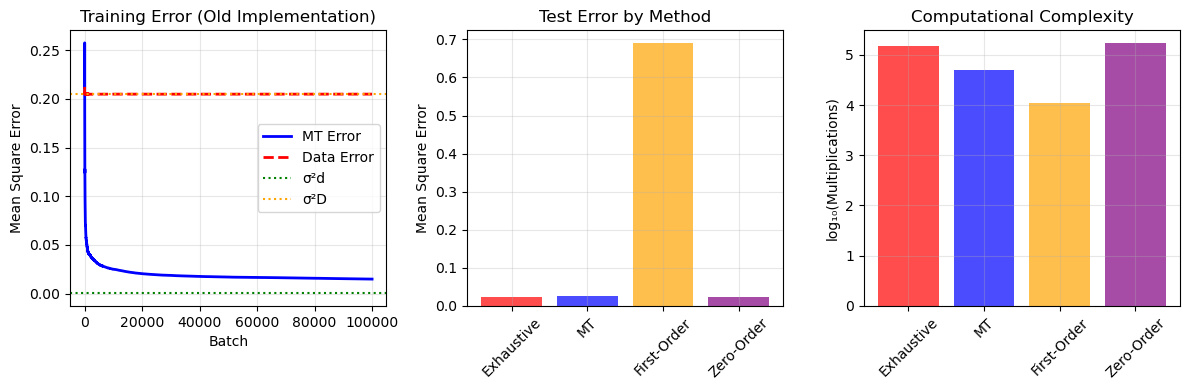

In [9]:
print("="*60)
print("VISUALIZATIONS")
print("="*60)

# training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(errors[0], 'b-', label='MT Error', linewidth=2)
plt.plot(errors[1], 'r--', label='Data Error', linewidth=2)
plt.axhline(y=sigma**2 * d, color='g', linestyle=':', label=f'σ²d')
plt.axhline(y=sigma**2 * D, color='orange', linestyle=':', label=f'σ²D')
plt.xlabel('Batch')
plt.ylabel('Mean Square Error')
plt.title('Training Error (Old Implementation)')
plt.legend()
plt.grid(True, alpha=0.3)

# performance comparison
plt.subplot(1, 3, 2)
methods = ['Exhaustive', 'MT', 'First-Order', 'Zero-Order']
errors_plot = [avg_exh_dist, avg_mt_dist, avg_FOM_dist, avg_ZOM_dist]
colors = ['red', 'blue', 'orange', 'purple']
plt.bar(methods, errors_plot, color=colors, alpha=0.7)
plt.ylabel('Mean Square Error')
plt.title('Test Error by Method')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# complexity comparison
plt.subplot(1, 3, 3)
complexities = [avg_exh_mults, avg_mt_mults, avg_FOM_mults, avg_ZOM_mults]
plt.bar(methods, np.log10(np.maximum(complexities, 1)), color=colors, alpha=0.7)
plt.ylabel('log₁₀(Multiplications)')
plt.title('Computational Complexity')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

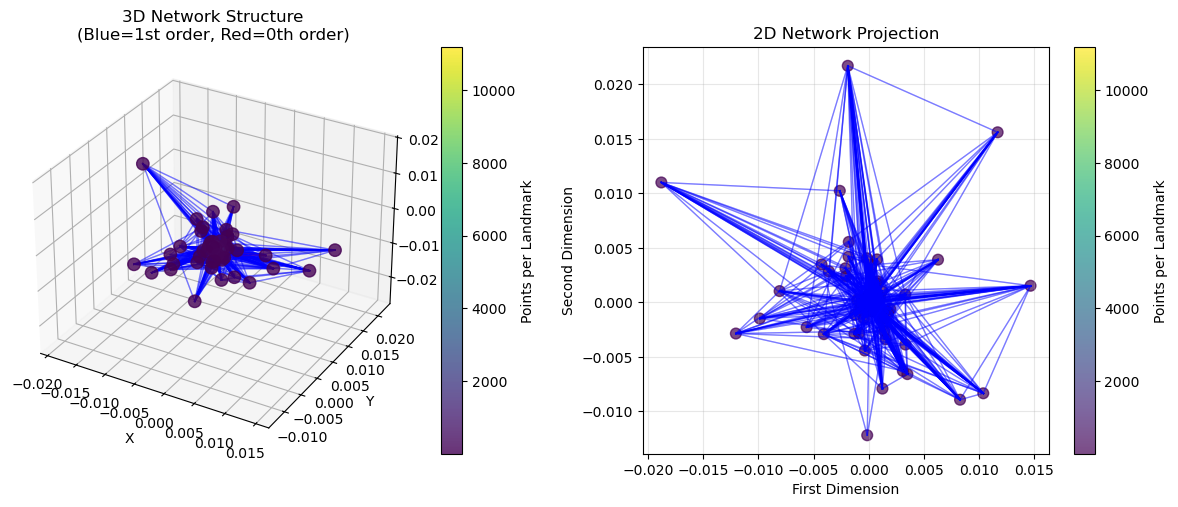

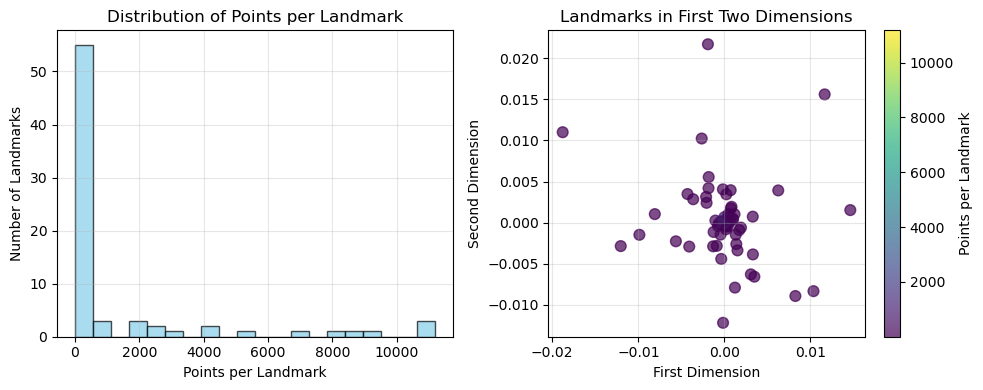

In [10]:
def visualize_old_network(Q, N1, N0, P, show_edges=True):
    Q_array = np.array(Q)
    
    if Q_array.shape[1] >= 3:
        fig = plt.figure(figsize=(12, 5))
        
        ax1 = fig.add_subplot(121, projection='3d')
        
        scatter = ax1.scatter(Q_array[:, 0], Q_array[:, 1], Q_array[:, 2], 
                             c=P, cmap='viridis', s=80, alpha=0.8)
        plt.colorbar(scatter, ax=ax1, label='Points per Landmark')
        
        if show_edges:
            for i, neighbors in enumerate(N1):
                for neighbor_idx in neighbors:
                    if neighbor_idx < len(Q):
                        ax1.plot([Q[i][0], Q[neighbor_idx][0]], 
                                [Q[i][1], Q[neighbor_idx][1]], 
                                [Q[i][2], Q[neighbor_idx][2]], 
                                'b-', alpha=0.3, linewidth=1)
            
            for i, neighbors in enumerate(N0):
                for neighbor_idx in neighbors:
                    if neighbor_idx < len(Q) and neighbor_idx not in N1[i]:
                        ax1.plot([Q[i][0], Q[neighbor_idx][0]], 
                                [Q[i][1], Q[neighbor_idx][1]], 
                                [Q[i][2], Q[neighbor_idx][2]], 
                                'r-', alpha=0.2, linewidth=0.5)
        
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y') 
        ax1.set_zlabel('Z')
        ax1.set_title('3D Network Structure\n(Blue=1st order, Red=0th order)')
        
        ax2 = fig.add_subplot(122)
        scatter2 = ax2.scatter(Q_array[:, 0], Q_array[:, 1], 
                              c=P, cmap='viridis', s=60, alpha=0.7)
        plt.colorbar(scatter2, ax=ax2, label='Points per Landmark')
        
        if show_edges:
            # Draw first-order edges
            for i, neighbors in enumerate(N1):
                for neighbor_idx in neighbors:
                    if neighbor_idx < len(Q):
                        ax2.plot([Q[i][0], Q[neighbor_idx][0]], 
                                [Q[i][1], Q[neighbor_idx][1]], 
                                'b-', alpha=0.3, linewidth=1)
        
        ax2.set_xlabel('First Dimension')
        ax2.set_ylabel('Second Dimension')
        ax2.set_title('2D Network Projection')
        ax2.grid(True, alpha=0.3)
        
    else:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(Q_array[:, 0], Q_array[:, 1], 
                             c=P, cmap='viridis', s=60, alpha=0.7)
        plt.colorbar(scatter, label='Points per Landmark')
        
        if show_edges:
            # Draw edges
            for i, neighbors in enumerate(N1):
                for neighbor_idx in neighbors:
                    if neighbor_idx < len(Q):
                        plt.plot([Q[i][0], Q[neighbor_idx][0]], 
                                [Q[i][1], Q[neighbor_idx][1]], 
                                'b-', alpha=0.3, linewidth=1)
        
        plt.xlabel('First Dimension')
        plt.ylabel('Second Dimension')
        plt.title('Network Structure')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if M > 0:
    visualize_old_network(Q, N1, N0, P, show_edges=True)
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(P, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Points per Landmark')
    plt.ylabel('Number of Landmarks')
    plt.title('Distribution of Points per Landmark')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    if len(Q) > 0:
        Q_array = np.array(Q)
        plt.scatter(Q_array[:, 0], Q_array[:, 1], 
                   c=P, cmap='viridis', s=60, alpha=0.7)
        plt.colorbar(label='Points per Landmark')
        plt.xlabel('First Dimension')
        plt.ylabel('Second Dimension')
        plt.title('Landmarks in First Two Dimensions')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [11]:
print("="*60)
print("SINGLE SAMPLE DENOISING DEMONSTRATION")
print("="*60)

def denoise_single_sample(x, network_params):
    """Denoise a single sample using the old network format."""
    # unpack data
    [local_params, nbrs_info, misc] = network_params
    (Q, T, S_collection, P, Xi) = local_params
    (N1, W1, N0, W0) = nbrs_info
    (tangent_colors, D, d, M, P) = misc
    
    if M == 0:
        return x.copy()
    
    # perform traversal to find best landmark
    i, phi, trajectory, edge_orders, mults = MT_perform_traversal(x, Q, T, N1, W1, Xi, N0, W0, calc_mults=False)
    
    # denoise using local model at best landmark
    return MT_denoise_local(x, Q, T, i)

# pick a test sample for demonstration
demo_idx = 0
x_clean_demo = X_natural_test[:, demo_idx]
x_noisy_demo = X_test[:, demo_idx]

# denoise using trained network
x_denoised_demo = denoise_single_sample(x_noisy_demo, network_params)

# compute corr
correlation_denoised = np.corrcoef(x_denoised_demo, x_clean_demo)[0, 1]

print(f"Correlation (denoised vs clean): {correlation_denoised:.4f}")


SINGLE SAMPLE DENOISING DEMONSTRATION
Correlation (denoised vs clean): 0.9978


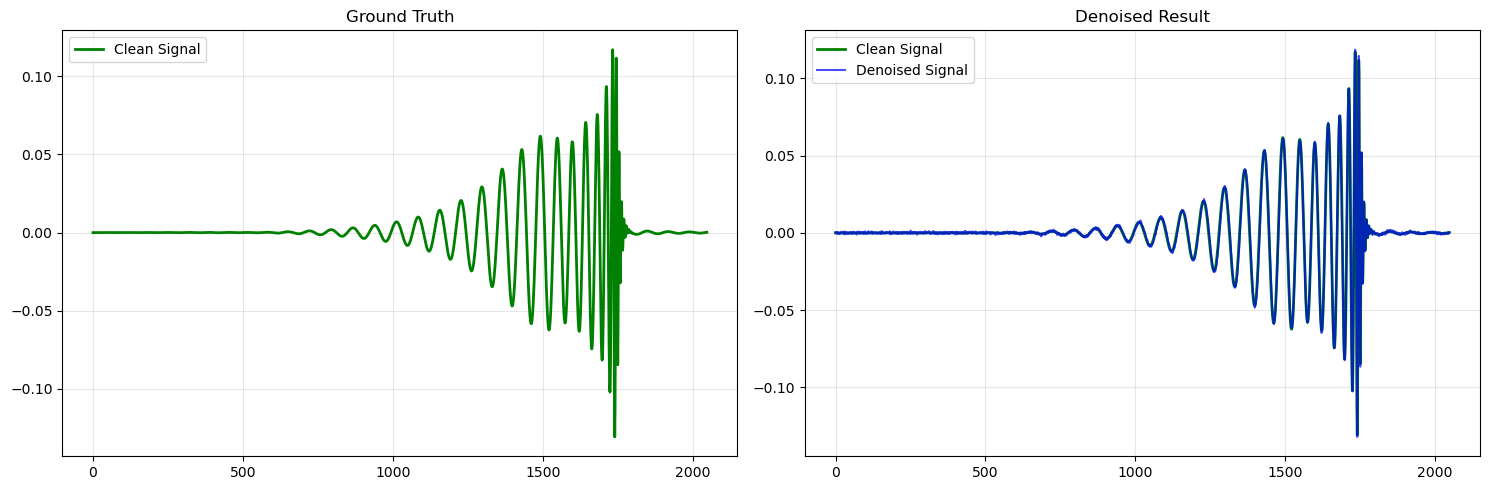

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x_clean_demo, 'g-', linewidth=2, label='Clean Signal')
plt.title('Ground Truth')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_clean_demo, 'g-', linewidth=2, label='Clean Signal')
plt.plot(x_denoised_demo, 'b-', alpha=0.7, label='Denoised Signal')
plt.title(f'Denoised Result')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()